## MSE for many bergs

In [18]:
drift_model = 'turnbull'  # must be 'turnbull' or 'wagner'
ocean_model = 'ecmwf'  # must be 'ecmwf'
atm_model = 'ecmwf'  # must be 'ecmwf'

In [2]:
from datetime import timedelta
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import pandas as pd

if drift_model == 'turnbull':
    from icedef.turnbull import drift
elif drift_model == 'wagner':
    from icedef.wagner import drift
else:
    print('drift model specified is invalid')
    
from icedef import iceberg, metocean, plot, timesteppers

In [3]:
def get_mse(iip_berg, mod_berg):

    dt_list = []
    mse_list = []
    
    if not mod_berg.out_of_bounds:
        mod_idxs = plot.find_matching_value_indices(iip_berg.history['T'], mod_berg.history['T'])


        for iip_idx, mod_idx in enumerate(mod_idxs):
            if not mod_idx == 0:
                dx = iip_berg.history['X'][iip_idx] - mod_berg.history['X'][mod_idx]
                dy = iip_berg.history['Y'][iip_idx] - mod_berg.history['Y'][mod_idx]
                tdelta = mod_berg.history['T'][mod_idx] - mod_berg.history['T'][0]  # timedelta
                dt = tdelta.days*24 + tdelta.seconds/3600  # hours
                mse = np.sqrt(dx**2 + dy**2)
                dt_list.append(dt)
                mse_list.append(mse)
    
    #dt_mse_list = list(zip(dt_list,mse_list))
    
    return dt_list, mse_list

In [17]:
iip_df = pd.read_csv('csvs/2015_max12hr_tracks').reset_index(drop=True)

iip_df.loc[:,'TIMESTAMP'] = pd.to_datetime(iip_df['TIMESTAMP'])

In [5]:
dt = 0.1  # timestep in hours

In [13]:
all_dt = []
all_mse = []

for track_num in range(int(max(iip_df['track_num']))):
    #for track_num in range(0):
    
    print(track_num)
    
    berg_df = iip_df.loc[iip_df['track_num']==track_num].reset_index(drop=True)
    iip_berg = iceberg.get_iip_berg(berg_df)

    ocean_data = metocean.ECMWF_Ocean(min(iip_berg.history['X']), max(iip_berg.history['X']),
                             min(iip_berg.history['Y']), max(iip_berg.history['Y']),
                             iip_berg.history['T'][0], iip_berg.history['T'][-1])

    atm_data = metocean.ECMWF_Atm(min(iip_berg.history['X']), max(iip_berg.history['X']),
                             min(iip_berg.history['Y']), max(iip_berg.history['Y']),
                             iip_berg.history['T'][0], iip_berg.history['T'][-1])


    t0 = iip_berg.history['T'][0]
    tf = iip_berg.history['T'][-1]

    t_all = timesteppers.get_all_timesteps(t0, tf, dt)

    mod_berg = iceberg.clone_iceberg_state(iip_berg)

    mod_berg = timesteppers.euler(mod_berg, ocean_data, atm_data, drift, t_all)

    dt_list, mse_list = get_mse(iip_berg, mod_berg)

    all_dt += [dt for dt in dt_list]
    all_mse += [mse for mse in mse_list]

0
Beware, wind speeds are (-3212.035103110877,-3199.2018097775567)
Beware, wind speeds are (-3212.001661777552,-3199.1938334442257)
Iceberg out-of-bounds
1
2
Beware, wind speeds are (-32256.82439999974,-32257.06937199974)
Beware, wind speeds are (-32256.823924199736,-32257.069566999737)
Iceberg out-of-bounds
3
4
5
Beware, wind speeds are (-4468.4638453000025,-4482.958137255566)
Beware, wind speeds are (-4468.440726700008,-4482.960575188899)
Iceberg out-of-bounds
6
7
8
Beware, wind speeds are (-11138.041705000105,-11149.53461500011)
Beware, wind speeds are (-11138.033015000108,-11149.53054500011)
Iceberg out-of-bounds
9
Beware, wind speeds are (-32768.0,-32768.0)
Beware, wind speeds are (-32768.0,-32768.0)
Iceberg out-of-bounds
10
Beware, wind speeds are (-17700.70291461085,-17694.023120444188)
Beware, wind speeds are (-17700.70186427752,-17694.03299511085)
Iceberg out-of-bounds
11
12
13
14
15
16
Beware, wind speeds are (-31942.12684979999,-31942.56058099999)
Beware, wind speeds are (-3

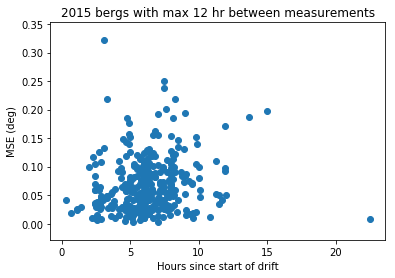

In [15]:
plt.scatter(all_dt, all_mse)
plt.title('2015 bergs with max 12 hr between measurements')
plt.xlabel('Hours since start of drift')
plt.ylabel('MSE (deg)')
plt.show()